# Transfer Learning with PyTorch
Create the following databricks libraries and attach to cluster:
* http://download.pytorch.org/whl/cu90/torch-0.4.1-cp35-cp35m-linux_x86_64.whl 
* torchvision

*See https://docs.databricks.com/applications/deep-learning/pytorch.html*

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

data_path = '/dbfs/gear_images/'

In [3]:
# Function to load data

def load_dataset():
    
    # Resize to 256 x 256, center-crop to 224x224 (to match the resnet image size), and convert to Tensor
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
    
    # Load all of the images, transforming them to tensors
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the traiuning data we can iterate through in 32-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 32-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


In [4]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    print("Epoch:", epoch)
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return train_loss / (batch_idx + 1)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss


In [5]:
import os

# Get the class names
classes = os.listdir(data_path)
classes.sort()

# Load the base model 
resnet = models.resnet18(pretrained=True)

# Freeze the layers
for param in resnet.parameters():
    param.requires_grad = False

# Add the final dense layer for our classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(classes))

# Get the data
print("Loading data...")
train_loader, test_loader = load_dataset()

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

model = resnet.to(device)
print('training based on', len(classes), 'classes using', device)
optimizer = optim.Adam(resnet.parameters(), lr=0.01)
loss_criteria = nn.CrossEntropyLoss()
epochs = 3
training_loss = []
validation_loss = []
epoch_nums = []
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
0.0%0.0%0.1%0.1%0.1%0.1%0.1%0.1%0.2%0.2%0.2%0.2%0.2%0.2%0.3%0.3%0.3%0.3%0.3%0.3%0.4%0.4%0.4%0.4%0.4%0.5%0.5%0.5%0.5%0.5%0.5%0.6%0.6%0.6%0.6%0.6%0.6%0.7%0.7%0.7%0.7%0.7%0.8%0.8%0.8%0.8%0.8%0.8%0.9%0.9%0.9%0.9%0.9%0.9%1.0%1.0%1.0%1.0%1.0%1.0%1.1%1.1%1.1%1.1%1.1%1.2%1.2%1.2%1.2%1.2%1.2%1.3%1.3%1.3%1.3%1.3%1.3%1.4%1.4%1.4%1.4%1.4%1.5%1.5%1.5%1.5%1.5%1.5%1.6%1.6%1.6%1.6%1.6%1.6%1.7%1.7%1.7%1.7%1.7%1.7%1.8%1.8%1.8%1.8%1.8%1.9%1.9%1.9%1.9%1.9%1.9%2.0%2.0%2.0%2.0%2.0%2.0%2.1%2.1%2.1%2.1%2.1%2.2%2.2%2.2%2.2%2.2%2.2%2.3%2.3%2.3%2.3%2.3%2.3%2.4%2.4%2.4%2.4%2.4%2.4%2.5%2.5%2.5%2.5%2.5%2.6%2.6%2.6%2.6%2.6%2.6%2.7%2.7%2.7%2.7%2.7%2.7%2.8%2.8%2.8%2.8%2.8%2.9%2.9%2.9%2.9%2.9%2.9%3.0%3.0%3.0%3.0%3.0%3.0%3.1%3.1%3.1%3.1%3.1%3.1%3.2%3.2%3.2%3.2%3.2%3.3%3.3%3.3%3.3%3.3%3.3%3.4%3.4%3.4%3.4%3.4%3.4%3.5%3.5%3.5%3.5%3.5%3.6%3.6%3.6%3.6%3.6%3.6%3.7%3.7%3.7%3.7%3.7%3.7%3.8%3.8%3.8%3.8%3.8%3.8%3.9%3.9%3.9%3.9%3.9%4.0%4.0%4.0%4.0%4.0%4.0%4.1%4.1%4.1%4.1%4.1%4.1%4.2%4.2%4.2%4.2%4.2%4.3%4.3%4.3%4.3%4.3%4.3%4.4%4.4%4.4%4.4%4.4%4.4%4.5%4.5%4.5%4.5%4.5%4.5%4.6%4.6%4.6%4.6%4.6%4.7%4.7%4.7%4.7%4.7%4.7%4.8%4.8%4.8%4.8%4.8%4.8%4.9%4.9%4.9%4.9%4.9%5.0%5.0%5.0%5.0%5.0%5.0%5.1%5.1%5.1%5.1%5.1%5.1%5.2%5.2%5.2%5.2%5.2%5.2%5.3%5.3%5.3%5.3%5.3%5.4%5.4%5.4%5.4%5.4%5.4%5.5%5.5%5.5%5.5%5.5%5.5%5.6%5.6%5.6%5.6%5.6%5.7%5.7%5.7%5.7%5.7%5.7%5.8%5.8%5.8%5.8%5.8%5.8%5.9%5.9%5.9%5.9%5.9%5.9%6.0%6.0%6.0%6.0%6.0%6.1%6.1%6.1%6.1%6.1%6.1%6.2%6.2%6.2%6.2%6.2%6.2%6.3%6.3%6.3%6.3%6.3%6.4%6.4%6.4%6.4%6.4%6.4%6.5%6.5%6.5%6.5%6.5%6.5%6.6%6.6%6.6%6.6%6.6%6.6%6.7%6.7%6.7%6.7%6.7%6.8%6.8%6.8%6.8%6.8%6.8%6.9%6.9%6.9%6.9%6.9%6.9%7.0%7.0%7.0%7.0%7.0%7.1%7.1%7.1%7.1%7.1%7.1%7.2%7.2%7.2%7.2%7.2%7.2%7.3%7.3%7.3%7.3%7.3%7.3%7.4%7.4%7.4%7.4%7.4%7.5%7.5%7.5%7.5%7.5%7.5%7.6%7.6%7.6%7.6%7.6%7.6%7.7%7.7%7.7%7.7%7.7%7.7%7.8%7.8%7.8%7.8%7.8%7.9%7.9%7.9%7.9%7.9%7.9%8.0%8.0%8.0%8.0%8.0%8.0%8.1%8.1%8.1%8.1%8.1%8.2%8.2%8.2%8.2%8.2%8.2%8.3%8.3%8.3%8.3%8.3%8.3%8.4%8.4%8.4%8.4%8.4%8.4%8.5%8.5%8.5%8.5%8.5%8.6%8.6%8.6%8.6%8.6%8.6%8.7%8.7%8.7%8.7%8.7%8.7%8.8%8.8%8.8%8.8%8.8%8.9%8.9%8.9%8.9%8.9%8.9%9.0%9.0%9.0%9.0%9.0%9.0%9.1%9.1%9.1%9.1%9.1%9.1%9.2%9.2%9.2%9.2%9.2%9.3%9.3%9.3%9.3%9.3%9.3%9.4%9.4%9.4%9.4%9.4%9.4%9.5%9.5%9.5%9.5%9.5%9.6%9.6%9.6%9.6%9.6%9.6%9.7%9.7%9.7%9.7%9.7%9.7%9.8%9.8%9.8%9.8%9.8%9.8%9.9%9.9%9.9%9.9%9.9%10.0%10.0%10.0%10.0%10.0%10.0%10.1%10.1%10.1%10.1%10.1%10.1%10.2%10.2%10.2%10.2%10.2%10.3%10.3%10.3%10.3%10.3%10.3%10.4%10.4%10.4%10.4%10.4%10.4%10.5%10.5%10.5%10.5%10.5%10.5%10.6%10.6%10.6%10.6%10.6%10.7%10.7%10.7%10.7%10.7%10.7%10.8%10.8%10.8%10.8%10.8%10.8%10.9%10.9%10.9%10.9%10.9%11.0%11.0%11.0%11.0%11.0%11.0%11.1%11.1%11.1%11.1%11.1%11.1%11.2%11.2%11.2%11.2%11.2%11.2%11.3%11.3%11.3%11.3%11.3%11.4%11.4%11.4%11.4%11.4%11.4%11.5%11.5%11.5%11.5%11.5%11.5%11.6%11.6%11.6%11.6%11.6%11.7%11.7%11.7%11.7%11.7%11.7%11.8%11.8%11.8%11.8%11.8%11.8%11.9%11.9%11.9%11.9%11.9%11.9%12.0%12.0%12.0%12.0%12.0%12.1%12.1%12.1%12.1%12.1%12.1%12.2%12.2%12.2%12.2%12.2%12.2%12.3%12.3%12.3%12.3%12.3%12.4%12.4%12.4%12.4%12.4%12.4%12.5%12.5%12.5%12.5%12.5%12.5%12.6%12.6%12.6%12.6%12.6%12.6%12.7%12.7%12.7%12.7%12.7%12.8%12.8%12.8%12.8%12.8%12.8%12.9%12.9%12.9%12.9%12.9%12.9%13.0%13.

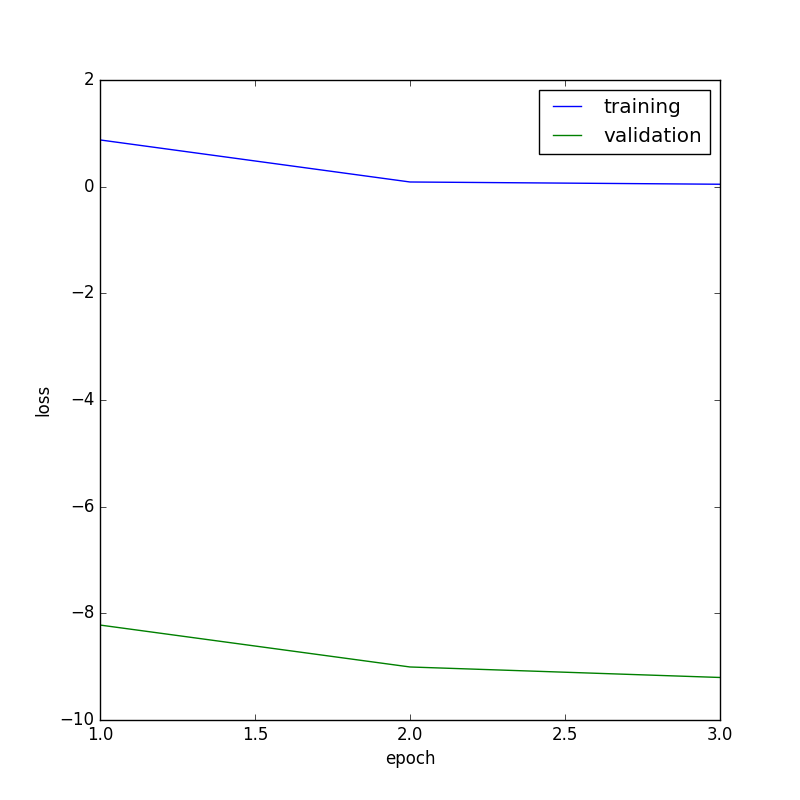

In [6]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8, 8))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()
display(fig)

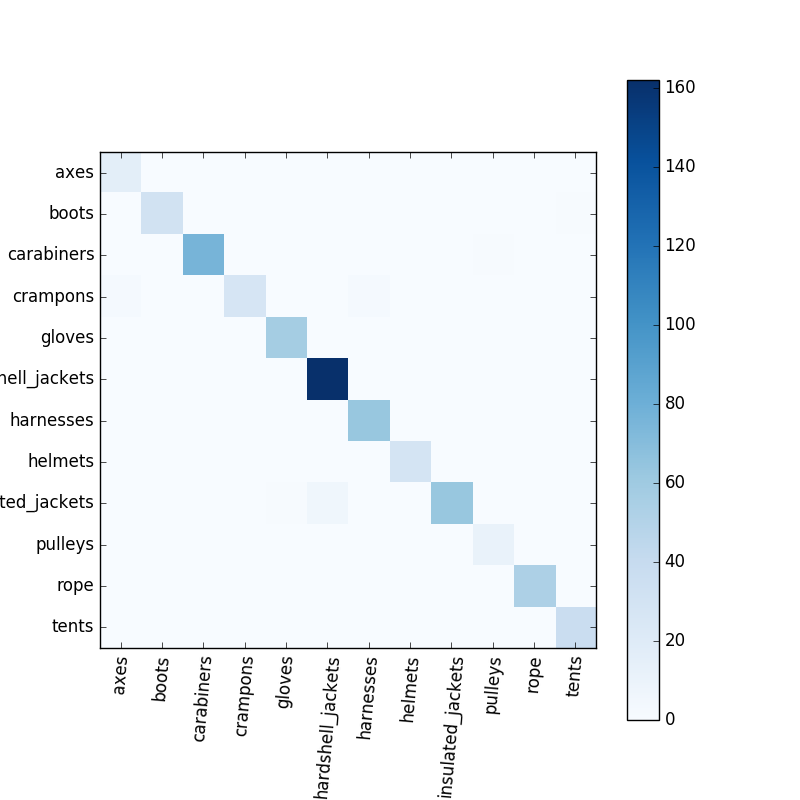

In [7]:
#Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
fig = plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=85)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()
display(fig)

In [8]:
def predict_image(classifier, image):
    import numpy

    classifier.eval()
    
   # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input)
    index = output.data.numpy().argmax()
    return index

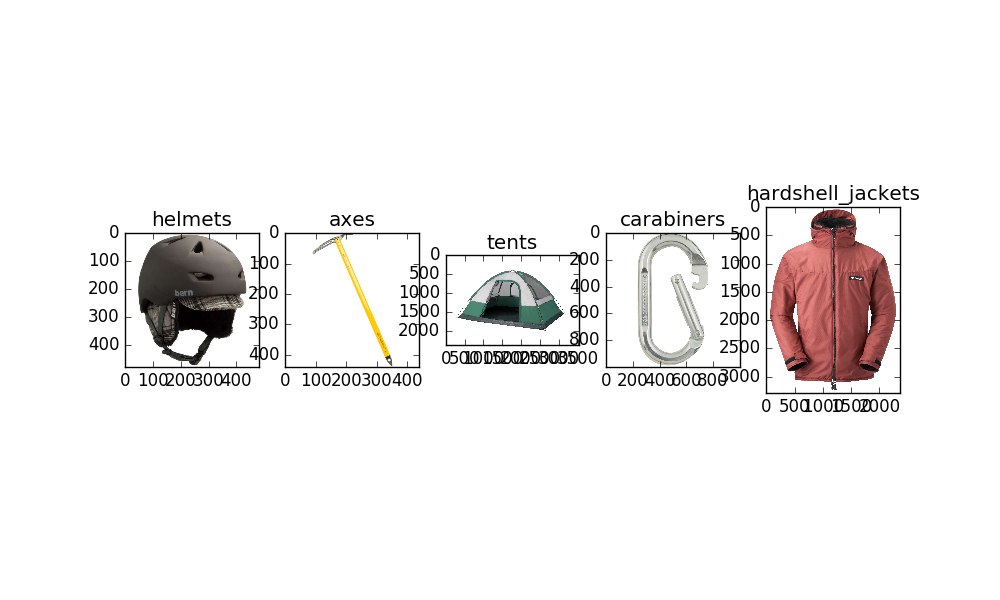

In [9]:
# Predict class for new data
from PIL import Image, ImageOps
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

image_urls = []
image_urls.append('https://i.stack.imgur.com/5I4Rx.jpg')
image_urls.append('https://i.stack.imgur.com/HeliW.jpg')
image_urls.append('https://productimages.camping-gear-outlet.com/e5/62379.jpg')
image_urls.append('http://s7d1.scene7.com/is/image/MoosejawMB/MIKAJMKFMKCAPNABx1024698_zm?$product1000$')
image_urls.append('http://www.buffalosystems.co.uk/wp-content/uploads/2012/06/zoom_apline_jacket_dark_russet-2365x3286.jpg')

fig = plt.figure(figsize=(10, 6))

# Get the images and show the predicted classes
for url_idx in range(len(image_urls)):
    response = requests.get(image_urls[url_idx])
    img = Image.open(BytesIO(response.content))
    class_idx = predict_image(resnet, img)
    class_name = classes[class_idx]
    a=fig.add_subplot(1,len(image_urls),url_idx+1)
    imgplot = plt.imshow(img)
    a.set_title(class_name)
    
display(fig)